## 7-1. 量子位相推定アルゴリズム詳説：水素分子への応用を例として
この節では、量子位相推定アルゴリズム (Quantum Phase Estimation, QPE) の復習をするとともに、QPEを用いて量子多体系のハミルトニアン（水素分子）の固有値を求めてみる。その過程で、QPEを実際の問題に応用する際の流れやテクニックを詳しく学んでいく。

###  位相推定の復習
[2-4. 位相推定アルゴリズム（入門編）](2.4_phase_estimation_beginner.ipynb)で既に学んだように、QPEは、適当なユニタリ行列 $U$ が与えられたときにその固有値 $e^{i \lambda}$ をビット列として取り出すアルゴリズムである。
QPEをサブルーチンとして用いることで、素因数分解や量子多体系のエネルギー計算といった（ユニタリ行列の固有値問題に帰着できる）多くの問題を、古典コンピュータと比べて非常に高速に解けるようになることが期待されている。


具体的にQPEの変換を思い出してみよう。$U$ の $i$番目の固有値 $e^{i \lambda_i}$ に対応する固有ベクトルを $| u_i \rangle$ とする ($U | u_i \rangle = e^{i \lambda_i} | u_i \rangle$)。この時、制御ユニタリ演算 $\Lambda (U)$ と量子フーリエ変換を用いて、QPEは次の変換を実現する。

$$
| u_i \rangle | 0 \rangle{}^{\otimes{t}} \xrightarrow{\text{QPE}} | u_i \rangle | \tilde{\lambda_i} \rangle.
$$

ここで、 $| 0 \rangle{}^{\otimes{t}}$ は $t$ 個の補助量子ビットであり、$\tilde{\lambda_i}=j_1j_2 \ldots j_t$ は $\lambda_i$ を $t$ 桁目まで2進展開したビット列

$$
\frac{\lambda_i}{2 \pi} = \frac{j_1}{2} + \frac{j_2}{2^2} + \ldots + \frac{j_t}{2^t} = 0.j_1 j_2 \ldots j_t
$$ 

である。 (  $(t+1)$ 桁目以降は省略した)


このQPEを実用的な問題に対して実行するには、誤り訂正機能のある量子コンピュータが必要であると考えられている (long-term アルゴリズム)。主な理由としては、

- 補助ビットの数
- 制御ユニタリゲート $\Lambda (U^{2^{k-1}})$ ($k =1, ..., t$) の複雑さ

といった点が挙げられる。まず補助ビットの数についてだが、例えば現在の古典コンピュータで使われているような倍精度実数の精度で $\lambda_i$ を求めるには50個以上の補助ビットが必要になる 。
そして、そのような多数の補助ビット（つまり大きな $t$ ）を用いる場合、制御ユニタリゲート $\Lambda (U^{2^{k-1}})$ ($k =1, ..., t$) を $U$ の非常に大きなべき乗に対して用意する必要が生じる。
このような制御ゲートを用意する難しさは $U$ としてどのような行列を考えるかに依存するが、一般には簡単でない：
後で見るように、QPEの応用が最も期待されている問題の一つである「エルミート行列 $H$ の固有値問題」の場合は、$U$ を $H$ による時間発展演算子、つまり$U = e^{-iH\tau}$ ($\tau$は定数) とおくので、$U$ の大きなべきは $H$ による（精度の逆数に対して指数関数的に）長時間の時間発展をシミュレーションすることを意味する。これは非常に難しい。

### 反復的位相推定
実は、$U$ の固有値のみに興味があり固有状態が必要ないのであれば、QPEの補助ビットを減らすことができる。
これは反復的位相推定法 (Iterative Quantum Phase Estimation (IQPE), https://journals.aps.org/pra/abstract/10.1103/PhysRevA.76.030306) と呼ばれており、すでに[2-4節](2.4_phase_estimation_beginner.ipynb)の「はじめに：アダマールテストを改良する」の箇所で紹介した方法と等価なのだが、ここに改めて記しておく。

IQPEは固有値を2進展開したビット列を、各桁ごとに決定論的に求める方法である。必要な補助ビットは1つで、1イテレーションごとに固有値の2進小数表示 $0.j_1...j_t$ の1つの桁の値 ($j_k$) を求める。
手順は以下の通りである ($k = t, t-1, \ldots, 1$とイテレーションする)：

#### $k = t$ のとき
1. 補助ビットにアダマールゲートをかける

$$
| 0 \rangle | u_i \rangle \xrightarrow{H} \frac{1}{\sqrt{2}} \left( |0\rangle + |1\rangle \right) | u_i \rangle  
$$

2. 補助ビットに $\Lambda (U^{2^{t-1}})$ をかける

$$
\frac{1}{\sqrt{2}} \left( |0\rangle + |1\rangle \right) | u_i \rangle  \xrightarrow{\Lambda (U^{2^{t-1}})} \frac{1}{\sqrt{2}} \left(| 0 \rangle + e^{i \pi j_t} | 1 \rangle \right) | u_i \rangle 
$$

3. 補助ビットにアダマールゲートをかけて測定する

$$
\frac{1}{\sqrt{2}} \left(| 0 \rangle + e^{i \pi j_t} | 1 \rangle \right) | u_i \rangle  \xrightarrow{H} \frac{1}{2} [ (1 + e^{i \pi j_t})| 0 \rangle + (1 - e^{i \pi j_t}) | 1 \rangle]   |u_i \rangle =  | j_t \rangle | u_i \rangle  \xrightarrow{\textrm{Measure}} j_t
$$

4. 測定結果 $j_t$ を、蓄積位相 $\Phi(t)$ に反映させる: $\Phi(t) = \pi \cdot \frac{j_t}{2} = \pi 0. j_t$

#### $k = t-1, t-2, \ldots, 1$ のとき
1. 補助ビットにアダマールゲートをかける

$$
| 0 \rangle | u_i \rangle \xrightarrow{H} \frac{1}{\sqrt{2}} \left( |0\rangle + |1\rangle \right) | u_i \rangle  
$$

2. 補助ビットにZ回転ゲート $R_Z ( \Phi(k+1) )$ (ここで $R_Z(\theta)=e^{i\theta/2 Z}, \Phi(k+1) = \pi 0.j_{k+1} j_{k+2} \ldots j_{t}$となっている) をかける

$$
\frac{1}{\sqrt{2}} \left( |0\rangle + |1\rangle \right) | u_i \rangle \xrightarrow{R_Z} \frac{e^{i\Phi(k+1)/2}}{\sqrt{2}} (| 0 \rangle + e^{- i \pi 0.j_{k+1} j_{k+2} \ldots j_{t}} | 1 \rangle) | u_i \rangle 
$$

3. 補助ビットに $\Lambda (U^{2^{k-1}})$ をかける

$$
\frac{e^{i\Phi(k+1)/2}}{\sqrt{2}} (| 0 \rangle + e^{- i \pi 0.j_{k+1} j_{k+2} \ldots j_{t}} | 1 \rangle) | u_i \rangle \xrightarrow{\Lambda (U^{2^{k-1}})} \frac{e^{i\Phi(k+1)/2}}{\sqrt{2}} (| 0 \rangle + e^{i \pi j_k} | 1 \rangle) | u_i \rangle 
$$

4. 補助ビットにアダマールゲートをかけて測定する

$$
\frac{e^{i\Phi(k+1)/2}}{\sqrt{2}} (| 0 \rangle + e^{i \pi j_k} | 1 \rangle) | u_i \rangle  \xrightarrow{H} \frac{e^{i\Phi(k+1)/2}}{2}  [(1 + e^{i \pi j_k})| 0 \rangle + (1 - e^{i \pi j_k}) | 1 \rangle] | u_i \rangle = e^{i\Phi(k+1)/2} | j_k \rangle | u_i \rangle  \xrightarrow{\textrm{Measure}} j_k
$$

5. 測定結果 $j_k$ を 蓄積位相 $\Phi(k)$ に反映させる: 

$$
\Phi(k) = \frac{\Phi(k+1)}{2} + \pi \cdot \frac{j_k}{2} = \pi 0.j_{k} j_{k+1} \ldots j_{t}
$$

#### 全ての$j_k$ ($k = t, t-1, \ldots, 1$) を測定した後
所望の位相

$$
\lambda_i = 2 \Phi(1) = 2 \pi 0.j_1.j_2 \ldots j_{t}
$$

が得られる。

### 例： 量子位相推定アルゴリズムを用いた水素分子ハミルトニアンの基底状態エネルギーの計算

上記の反復的位相推定アルゴリズムを用いて、実際に水素分子の基底状態エネルギーを求めてみよう（以下の内容は論文[1] を参考としている）。
[4-1節](4.1_quantum_simulation.ipynb) や [6-1節](6.1_openfermion_basics.ipynb) で学んだように、水素分子の基底状態エネルギーとは、水素分子を表すハミルトニアン $H$ というエルミート行列の最小固有値のことである。
QPEやIQPEでは、ハミルトニアン $H$ の固有値問題を、その**時間発展演算子** $U = e^{−iH \tau}$ **の固有値を求める**ことで解いている。
ここで$\tau$は何らかの定数であり、$H$ の最小固有値と最大固有値を $E_{\text{min}}, E_{\text{max}}$ とした時に、$[ E_{\text{min}}, E_{\text{max}}]$ が $[0, 2\pi]$ に収まるようにとっておく（必要であれば、定数シフトも加える）。QPE・IQPEでは $U$ の固有値の位相には $2\pi$ の不定性があるが、こうしておけば $U$ の固有値から $H$ の固有値が一意に復元できるからだ。

基底エネルギー計算に必要なステップは以下の通りである:

0. （ハミルトニアンのサイズを対称性などを用いて削減する）
1. ハミルトニアンの時間発展演算子 $U=e^{-iH\tau}$ を精度よく近似する
2. 制御時間発展演算子を量子コンピュータで容易に実行可能なゲートセットに分解し実装する
3. 基底状態と十分重なりのある初期状態を準備する
4. IQPEでエネルギー固有値を測定する

以下、順を追って手法の詳細な説明と実装例を示す。

#### 0. （ハミルトニアンのサイズを対称性などを用いて削減する）
このステップは、実際にIQPEをシミュレータや実機で動かすときに、なるべくリソースを減らすために必要な工程であり、理論上必須ではない。
詳しくは文献 [1] に譲るが、水素分子の第二量子化されたハミルトニアン (STO-6G 基底) を Bravyi-Kitaev 変換で qubit 系にmapすると、そのままでは 4qubit  のハミルトニアン = $16 \times 16$ 行列になる。しかし、**ハミルトニアンの持つ対称性**（電子数保存則など）を用いてハミルトニアンを部分対角化して考えると、基底状態を求める際には 2 qubit で良いことがわかり、さらにそのハミルトニアンは以下のような6種類の項しか持たない。

$$
H = \sum_i g_i H_i = g_0 I + g_1 Z_0 + g_2 Z_1 + g_3 Z_0 Z_1 + g_4 Y_0 Y_1 + g_5 X_0 X_1
$$

ここで係数 $g_i$ は実数で、その値は水素分子の原子間距離（配置）に依存する。
化学に馴染みのない読者は、とにかく水素分子に対応した上記のエルミート行列が存在し、それの最小固有値を求めることが重要であるとだけ理解しておけば問題ない。

#### 1. ハミルトニアンの時間発展演算子 $U=e^{-iH\tau}$ を精度よく近似する
IQPEで用いる制御ユニタリ演算 $\Lambda (U^{2^k})$ を実装するため、まずは時間発展演算子 $U = e^{−iH \tau}$ を量子回路に実装する。
まず、定数項 $g_0 I$ と$g_3 Z_0 Z_1$ 項がハミルトニアンの他の全ての項と交換することに注意すると、$U$ は次のようになる。

$$
e^{−iH \tau} = \exp \left[−i \tau \sum_i g_i H_i \right] = \exp[−i \tau g_0 I] \exp[−i \tau g_3 Z_0 Z_1] \exp[−i \tau H_{\textrm{eff}}]
$$

ここで、$H_{\text{eff}}$ は

$$
H_{\text{eff}} = g_1 Z_0 + g_2 Z_1 + g_4 Y_0 Y_1 + g_5 X_0 X_1
$$

である。$g_0 I$ と$g_3 Z_0 Z_1$ 部分の固有値への寄与は後から簡単に加算することができるので、以下では $H_{\textrm{eff}}$ の固有値を $U_{\text{eff}}  := e^{−i H_{\text{eff}} \, \tau}$ のIQPEを用いて求めることを考える。

$U_{\text{eff}}$ をトロッター展開 ([4-2節](4.2_trotter_decomposition.ipynb)) すると、

$$
U_{\text{eff}} = \exp \left[−i \tau \sum_{i=1,2,4,5} g_i H_i \right] \approx U_{\text{Trot}}^{(N)} (\tau) := \left( \prod_{i=1,2,4,5} \exp[-i g_i H_i \tau/N] \right)^N
$$

となる。 $U_{\text{Trot}}^{(N)}$ に現れる積の各項は multi-qubit Pauli rotation gate、つまりパウリ行列の積の指数関数 $\exp(i\theta P)$ の形をしているので、簡単な量子ゲートの積として実装することが容易になっている。これで $U_{\textrm{eff}}$ を近似的に量子回路上へ実装することができた。

この近似のエラーについて調べてみよう。解析的にざっくりと評価すると

$$
\left| U_{\textrm{eff}} - U_{\textrm{Trot}}^{(N)} (\tau) \right| \sim \frac{\tau^2}{2N} \sum_{i > j} | [H_i, H_j] |
$$

となる[2]。この表式によると、欲しい精度 $\epsilon$ に対して $N \sim \tau^2/\epsilon$ 程度の大きさの $N$ をとれば良い事が分かる。
今回取り扱う系は $4 \times 4$ という小さい行列で表されるので、$H_{\textrm{eff}}$ を実際に厳密に対角化してみてその最小固有値 $E_{\textrm{min}}$ を求め、$U_{\textrm{Trot}}^{(N)}$ の固有値 $e^{i \lambda_{\textrm{Trot}}\tau}$ の $\lambda_{\textrm{Trot}}$ と比較してみよう。

まずは $H_{\textrm{eff}}$ の対角化を行う。エネルギーの単位は[ハートリー(Ha)](https://ja.wikipedia.org/wiki/ハートリー)というものが使われている。

In [1]:
from functools import reduce
import numpy as np
from numpy.linalg import matrix_power, eig
from scipy.sparse.linalg import eigsh
from openfermion.ops import QubitOperator
from openfermion.linalg import get_sparse_operator #エラーが出る場合は openfermion を version 1.0.0 以上にしてみてください
from qulacs import QuantumState, Observable, QuantumCircuit
import matplotlib.pyplot as plt

## Google Colaboratory / (Linux or Mac)のjupyter notebook 環境の場合にのみ実行してください。
## Qulacsのエラーが正常に出力されるようになります。
!pip3 install wurlitzer
%load_ext wurlitzer

In [2]:
def hamiltonian_eff():
    """
    distance = 0.70 A
    removed 'I' and 'Z0 Z1' terms, which add up to -1.31916027
    """
    n_qubits = 2
    g_list = [0.3593, 0.0896, -0.4826, 0.0896] ## taken from table 1 of paper [1]
    pauli_strings = ['Z0', 'Y0 Y1', 'Z1', 'X0 X1']
    hamiltonian = QubitOperator()
    for g, h in zip(g_list, pauli_strings):
        hamiltonian += g * QubitOperator(h)
    sparse_matrix = get_sparse_operator(hamiltonian, n_qubits=n_qubits)
    vals, vecs = eigsh(sparse_matrix, k=1, which='SA') ## only smallest eigenvalue and eigenvector are calculated
    return sparse_matrix, vals

In [3]:
_, eigs = hamiltonian_eff()
exact_eigenvalue = eigs[0] 
print('exact_eigenvalue: {:.10f} Ha'.format(exact_eigenvalue)) ## print eigenvalue up to 10 digits after decimal point

exact_eigenvalue: -0.8607602744 Ha


次に $U_{\textrm{Trot}}^{(N)}$ を対角化してみる。後のステップでは $U_{\textrm{Trot}}^{(N)}$ を量子回路として具体的に実装するが、ここでは $H_i^2 = I$ (恒等行列) の時

$$
\left( \prod_{i=1,2,4,5} \exp[-i g_i H_i \tau/N] \right)^N = \left( \prod_{i=1,2,4,5} \left( \cos(g_i\tau/N) I -i \sin(g_i\tau/N) H_i \right) \right)^N
$$

となる性質を用いて計算してしまう。
そして、$N = 1, 3, \ldots, 9$ において $U_{\textrm{Trot}}^{(N)}$ の固有値 $e^{-i \lambda_{\textrm{Trot}}\tau}$ の $\lambda_{\textrm{Trot}}$ を求め、 $E_{\textrm{min}}$ と比較する。

In [4]:
def order_n_trotter_approx(t, n_trotter_steps):
    """
    ordering: 'Z0', 'Y0 Y1', 'Z1', 'X0 X1'
    Returns:
        sparse_matrix: trotterized [exp(iHt/n)]^n
        args: list of phases of each eigenvalue, exp(i*phase)
    """
    n_qubits = 2
    g_list = [0.3593, 0.0896, -0.4826, 0.0896]
    pauli_strings = ['Z0', 'Y0 Y1', 'Z1', 'X0 X1']
    terms = []
    for g, h in zip(g_list, pauli_strings):
        arg = g * t / n_trotter_steps
        qop = complex(np.cos(arg), 0) * QubitOperator('') - complex(0, np.sin(arg)) * QubitOperator(h)
        terms += [get_sparse_operator(qop, n_qubits=n_qubits)]
    sparse_matrix = reduce(np.dot, terms) 
    matrix = matrix_power(sparse_matrix.toarray(), n_trotter_steps)  ## this is U_{trot}^{(N)}
    vals, vecs = eig(matrix)  ## e^{i lambda_{trot} }
    args = np.angle(vals) ## returns value in [-pi, pi] -> we don't modify output since we know exact value is around -0.86
    return sparse_matrix, sorted(args) ## we return sorted values

In [5]:
tau = 0.640 ## taken from table 1 of paper [1]
print('N, E_trot, |exact_eig - E_trot|')
for n in range(1, 10, 2):
    _, phases = order_n_trotter_approx(tau, n)
    e_trotter = phases[0]/tau
    print( f"{n}, {e_trotter:.10f}, {abs(exact_eigenvalue - e_trotter):.3e}" ) 

N, E_trot, |exact_eig - E_trot|
1, -0.8602760326, 4.842e-04
3, -0.8607068561, 5.342e-05
5, -0.8607410548, 1.922e-05
7, -0.8607504700, 9.804e-06
9, -0.8607543437, 5.931e-06


お分かり頂けただろうか？ 次数 $N$ が増えるごとに近似精度が上がっており、真のエネルギー固有値を chemical accuracy ( $1.6 × 10^{−3}$ Ha) と呼ばれる化学計算で必要な精度で近似するには $N = 1$ で今回は十分であることが分かる。

#### 2. 制御時間発展演算子を量子コンピュータで容易に実行可能なゲートセットに分解し実装する
量子コンピュータ上で制御時間発展演算子 $\Lambda \left( \left( U_{\textrm{Trot}}^{(N)} \right)^{2^k} \right)$ を実行するためには、これを簡単な量子ゲートに分解する必要がある。
今回の例では、 $U_{\textrm{Trot}}^{(N)}$ に含まれる

- $\Lambda(R_Z(\theta))$
- $\Lambda(R_{XX}(\theta))$
- $\Lambda(R_{YY}(\theta))$ 

という制御回転ゲートを分解できれば良い。ここで $R_Z(\theta) = e^{i\theta/2 Z_x}$ は $x=0,1$ 番目のqubitに作用する $Z$ 方向の回転ゲート、$R_{XX}(\theta) = e^{i\theta/2 X_0 X_1}, R_{YY}(\theta) = e^{i\theta/2 Y_0 Y_1}$ も回転ゲートである。 

まず、 $\Lambda(R_Z(\theta))$ は 制御ビット $| c \rangle$ と標的ビット $| t \rangle$ にかかると、

$$
\Lambda(R_Z(\theta)) | c \rangle | t \rangle = | c \rangle (R_Z(\theta))^c | t \rangle
$$

を満たすゲートである $(c=0,1)$ 。 $\textrm{CNOT} | c \rangle | t \rangle = | c \rangle X^c | t \rangle$、 $XZX = -Z$ が成り立つことに注意すると、

$$
\textrm{CNOT} \left(I \otimes R_Z(-\theta/2) \right) \textrm{CNOT} \left(I \otimes R_Z(\theta/2) \right) | c \rangle | t \rangle
= | c \rangle　X^c　R_Z(-\theta/2) X^c R_Z(\theta/2) | t \rangle
= | c \rangle \left(R_Z(\theta)\right)^c | t \rangle
$$

と式変形できるから、

$$
\Lambda(R_Z(\theta)) = \textrm{CNOT} \left(I \otimes R_Z(-\theta/2) \right) \textrm{CNOT} \left(I \otimes R_Z(\theta/2) \right)
$$

が言える。つまり、制御回転ゲート $\Lambda(R_Z(\theta))$ が CNOTゲートと $Z$ 回転ゲートという基本的なゲートを使って実装できた。

さらに、

$$
\textrm{CNOT}_{0,1} \left(I_0 \otimes Z_1 \right) \textrm{CNOT}_{0,1} = Z_0 \otimes Z_1
$$

の性質を用いると、$\Lambda(R_{ZZ}(\theta))$ が実現できる。
そして、$H Z H = X$　や $SH Z HS^{\dagger} = Y$ を用いると $\Lambda(R_{XX}(\theta))$、$\Lambda(R_{YY}(\theta))$ がそれぞれ実現できる。詳細は以下の実装も参照してほしい。

以下のコードでは、 Qulacs で制御時間発展演算子 $\Lambda \left( \left( U_{\textrm{Trot}}^{(N)} \right)^{2^k} \right)$ の量子回路を実装し、IQPEで実行すべき回路を作っている。回路図は以下のようである。

![IQPE回路](figs/7/IQPE.png)

In [6]:
def IQPE_circuit(g_list, tau, kickback_phase, k, n_trotter_step=1):
    n_qubits = 3 ## 2 for system, 1 for ancillary
    a_idx = 2 ## ancilla index
    phi = -(tau / n_trotter_step) * g_list ## coefficient for Pauli
    circuit = QuantumCircuit(n_qubits)
    ## Apply Hadamard to ancilla
    circuit.add_H_gate(a_idx)
    ## Apply kickback phase rotation to ancilla bit
    circuit.add_RZ_gate(a_idx, kickback_phase)
    ## controlled time evolution (Apply controll-e^{-iH*tau} for 2^{k-1} times
    for _ in range( 2 ** (k-1) ):
        for _ in range(n_trotter_step):
            # CU(Z0) i.e. controlled exp(i phi[0]*Z_0)
            circuit.add_RZ_gate(0, phi[0]) ## note that qulacs' RZ is defined as RZ(theta) = e^{i*theta/2*Z} 
            circuit.add_CNOT_gate(a_idx, 0)
            circuit.add_RZ_gate(0, -phi[0])
            circuit.add_CNOT_gate(a_idx, 0)
        
            # CU(Y0 Y1)
            circuit.add_Sdag_gate(0)
            circuit.add_Sdag_gate(1)
            circuit.add_H_gate(0)
            circuit.add_H_gate(1)
            circuit.add_CNOT_gate(0, 1)
            circuit.add_RZ_gate(1, phi[1])
            circuit.add_CNOT_gate(a_idx, 1)
            circuit.add_RZ_gate(1, -phi[1])
            circuit.add_CNOT_gate(a_idx, 1)
            circuit.add_CNOT_gate(0, 1)                
            circuit.add_H_gate(0)
            circuit.add_H_gate(1)
            circuit.add_S_gate(0)
            circuit.add_S_gate(1)
        
            # CU(Z1)
            circuit.add_RZ_gate(1, phi[2])
            circuit.add_CNOT_gate(a_idx, 1)
            circuit.add_RZ_gate(1, -phi[2])
            circuit.add_CNOT_gate(a_idx, 1)
        
            # CU(X0 X1)
            circuit.add_H_gate(0)
            circuit.add_H_gate(1)
            circuit.add_CNOT_gate(0, 1)
            circuit.add_RZ_gate(1, phi[3])
            circuit.add_CNOT_gate(a_idx, 1)
            circuit.add_RZ_gate(1, -phi[3])
            circuit.add_CNOT_gate(a_idx, 1)
            circuit.add_CNOT_gate(0, 1)     
            circuit.add_H_gate(0)
            circuit.add_H_gate(1)
            
    ## Apply Hadamard to ancilla
    circuit.add_H_gate(a_idx)
    return circuit

#### 3. 基底状態と十分重なりのある初期状態を準備する
これまでのQPE・IQPEの説明では、簡単のために $U$ が作用する状態はその固有状態であることを仮定してきた。実は、入力状態が「固有値を知りたい状態に十分近い（重なりがある）状態」であっても、十分高い精度でその固有値を求めることができる。

$|n \rangle$ をハミルトニアンの固有状態、それに対応する固有値を $E_n$ 、参照状態を $|\phi \rangle = \sum_n c_n |n \rangle$ とすると、QPE・IQPEの回路の作用は（$\tau=-1$とした）

$$
e^{iH } |0\ldots 0 \rangle  |\phi \rangle \xrightarrow{QPE} \sum_n c_n |\tilde{E_n} \rangle  |n \rangle 
$$

となる。ここで例えば1番目の補助ビット $j_1$ の測定が行われると、0が観測される確率は $\sum_{n \, \textrm{s.t.} \tilde{E_n}^{(1)}=0} |c_n|^2$ 、つまり固有値の2進小数展開の1桁目が0であるような固有値$E_n$についての重みの和に比例する。よって、もし $\{|c_n|^2\}_n$ の値が所望の状態についてのみ十分大きければ、$j_1$ の測定を繰り返して0か1か多く観測された方を採用すれば、所望の固有値が得られることが言える。（もう少し厳密な取り扱いは、Nielsen-Chuangの `Exercise 5.8` も参照）

今回の水素分子の基底エネルギーを求める問題の場合、 Hartree-Fock (HF) 状態 $|\phi \rangle = |01 \rangle$ が十分に基底状態に近い為、これを参照状態とする。（注：今回の問題では、HF状態が $|01\rangle$ になっている[1]）

#### 4. IQPEでエネルギー固有値を測定する
それでは、IQPEを実行してみよう。

以下の実装では、補助ビットなど特定の量子ビットのみを測定しその結果を用いる際に便利な `state.get_marginal_probability(bit_list)` を使っている。これは量子状態 `state` の特定の量子ビットが特定のビット値を持っている確率を、波動関数の振幅から計算する関数である。
例えば 補助ビット (`index=2`) が `0` 状態 (0、1番目の量子ビットに関しては測定しない) である
確率は、`get_marginal_probability([2, 2, 0])` で得られる (`2` は測定しない事を表している)。

In [7]:
from qulacs.circuit import QuantumCircuitOptimizer

def iterative_phase_estimation(g_list, tau, n_itter, init_state, n_trotter_step=1, kickback_phase=0.0):
    for k in reversed(range(1, n_itter+1)): ## run from n_itter to 1
        psi = init_state.copy()
        circuit = IQPE_circuit(np.array(g_list), tau, kickback_phase, k, n_trotter_step=n_trotter_step)
        ## 実行時間短縮のため回路の最適化を行う
        opt = QuantumCircuitOptimizer()
        max_block_size = 4
        opt.optimize(circuit, max_block_size)
        ## execute circuit
        circuit.update_quantum_state(psi)
        # partial trace
        p0 = psi.get_marginal_probability([2, 2, 0])
        p1 = psi.get_marginal_probability([2, 2, 1])
        # update kickback phase
        #print(f"k={k:2d}, p0={p0:.3f}, p1={p1:.3f}")
        kth_digit = 1 if (p0 < p1) else 0
        kickback_phase = 0.5 * kickback_phase + np.pi * 0.5 * kth_digit
    return 2 * kickback_phase

それでは、位相を何桁まで測定すれば良いか ($0.j_1 \ldots j_t$ の $t$ をどこまで大きくとるべきか) というベンチマークを取りつつ、IQPEを実行する。
化学で基底状態エネルギーの計算精度の一つの目安とされる chemical accuracy ($1.6 \times 10^{-3}$ Ha) の精度が必要な場合、イテレーションの回数を理論的に見積もると[3]

$$
t = - \log_2 (1.6 \times 10^{-3}) + \log_2 \left(2 + \frac{1}{2 \times 0.5} \right) \approx 10.87
$$

となる。
つまり $t = 11$ 程度にとれば十分そうであるが、実際に計算してみよう。

In [8]:
n_qubits = 3 # 2 for electron configurations and 1 for ancilla
g_list = [0.3593, 0.0896, -0.4826, 0.0896]
# pauli_strings = ['Z 0', 'Y 0 Y 1', 'Z 1', 'X 0 X 1']
hf_state = QuantumState(n_qubits)
hf_state.set_computational_basis(0b001) # |0>|01>
tau = 0.640

e_trotter = -0.8602760325707504 ## exact one of U_{Trot}^{(N)}
print(f"e_trotter={e_trotter:.10f}")

result_list = []
for n_itter in range(1, 12+1): # precission in digit
    iqpe_phase = iterative_phase_estimation(g_list, tau, n_itter, hf_state, n_trotter_step=1, kickback_phase=0.0)
    e_iqpe = - iqpe_phase/tau ## U=exp(-iH*tau) so the IQPE picks up eigenvalue of -H*tau  
    print(f"n_itter={n_itter:2d}, e_iqpe={e_iqpe:10f}, error={np.abs(e_iqpe-e_trotter):.5e}")
    result_list.append([n_itter, e_iqpe])
    
#print('e_iqpe = {} Ha, |e_iqpe-e_trotter| = {} Ha'.format(e_iqpe, abs(e_iqpe-e_trotter)))

e_trotter=-0.8602760326
n_itter= 1, e_iqpe= -0.000000, error=8.60276e-01
n_itter= 2, e_iqpe= -0.000000, error=8.60276e-01
n_itter= 3, e_iqpe= -1.227185, error=3.66909e-01
n_itter= 4, e_iqpe= -0.613592, error=2.46684e-01
n_itter= 5, e_iqpe= -0.920388, error=6.01124e-02
n_itter= 6, e_iqpe= -0.920388, error=6.01124e-02
n_itter= 7, e_iqpe= -0.843689, error=1.65866e-02
n_itter= 8, e_iqpe= -0.843689, error=1.65866e-02
n_itter= 9, e_iqpe= -0.862864, error=2.58816e-03
n_itter=10, e_iqpe= -0.862864, error=2.58816e-03
n_itter=11, e_iqpe= -0.858071, error=2.20553e-03
n_itter=12, e_iqpe= -0.860467, error=1.91316e-04


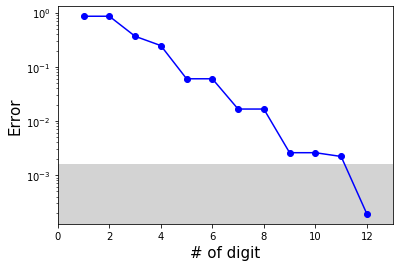

In [9]:
## 結果のプロット
result_array = np.array(result_list)
plt.xlabel("# of digit", fontsize=15)
plt.ylabel("Error", fontsize=15)
plt.semilogy(result_array[:,0], np.abs(result_array[:,1] - e_trotter), "bo-")
plt.xlim(0,13)
plt.fill_between([0,13], 1.6e-3, color = "lightgrey") ## fill the chemical accuracy region

お分かり頂けただろうか？ 予想通り `n_itter = 12` でようやく chemical accuracy に到達した。

ここで1点注意が必要なのは、ここで紹介したサンプルコードでは(制御)時間発展演算子 $\Lambda \left( \left( U_{\textrm{Trot}}^{(N)} \right)^{2^k} \right)$ のゲートの深さが $t$ に関して指数的に増大している事である。つまり、精度を上げるのに指数関数的に多くのゲートを用いなければならない。ここでは単純なトロッター分解に基づく方法を紹介したが、他の方法を使って時間発展演算子を効率的に実装する研究も数多くなされている。興味を持たれた読者は文献[4][5][6]を参照されたい。

### 参考文献
[1] P. J. J. O’Malley _et al._ , “Scalable Quantum Simulation of Molecular Energies“, [PHYSICAL REVIEW X 6, 031007 (2016)](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.6.031007)   
[2] S. Lloyd, “Universal Quantum Simulators“, [Science 273, Issue 5278, pp.1073-1078](https://science.sciencemag.org/content/273/5278/1073)   
[3] M. Nielsen and I. Chuang, “Quantum Computation and Quantum Information“ , Sec. 5.2   
[4] D. W. Berry, G. Ahokas, R. Cleve, B. C. Sanders, “Efficient quantum algorithms for simulating sparse Hamiltonians“,
[Communications in Mathematical Physics 270, 359 (2007)](https://link.springer.com/article/10.1007/s00220-006-0150-x)   
[5] D. W. Berry and  A. M. Childs,  “Black-box Hamiltonian simulation and unitary implementation“, [Quantum Information and Computation 12, 29 (2012)](http://www.rintonpress.com/journals/qiconline.html#v12n12)   
[6] D. W. Berry, A. M. Childs, R. Cleve, R. Kothari, and R. D. Somma,  “Simulating Hamiltonian dynamics with a truncated Taylor series“, 
[Phys. Rev. Lett. 114, 090502 (2015)](https://dx.doi.org/10.1103/PhysRevLett.114.090502)